In [1]:
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt

from matplotlib import colors
import rioxarray
import pyproj
from pysheds.grid import Grid
import numpy as np

import time
from shapely import geometry, ops
from shapely.geometry import Polygon
from shapely.geometry import Point
from rasterstats import zonal_stats
from rasterio.crs import CRS
from shapely.geometry.multipolygon import MultiPolygon
from shapely.ops import cascaded_union
from shapely.ops import unary_union
import fiona
import rasterio
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import pyproj
import os
from shapely import intersection
from shapely import intersects
from shapely import concave_hull
from shapely import difference, within, contains

Index(['geometry', 'FID', 'TBLE_NAME', 'NHD', 'METADATA', 'STNDRD_ID',
       'WBID_TXT', 'WATER_BODY', 'WB_CLS', 'DS_COUNTY', 'US_COUNTY', 'HUC_8',
       'SIZE_', 'UNIT', 'LEGAL_DS', 'AQL_USE', 'CDF_USE', 'DWS_USE', 'IND_USE',
       'IRR_USE', 'LWW_USE', 'SCR_USE', 'WBCA_USE', 'WBCB_USE', 'HHP_USE',
       'NNC', 'PERM_ID', 'REACHCODE', 'Shape__Area', 'Shape__Length'],
      dtype='object')

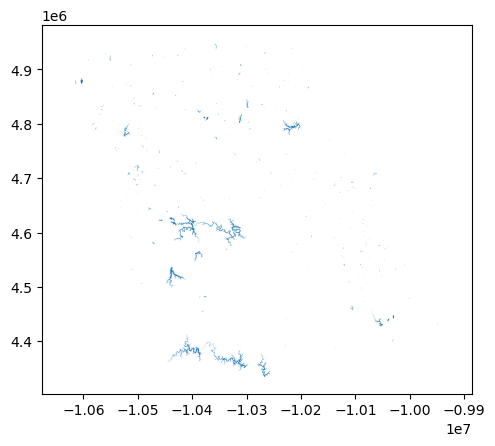

In [2]:
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)

MO_water = gpd.read_file("MO_2020_WQS_Lake_Classification_and_Use.geojson", driver='GeoJSON')
MO_water = MO_water.drop(columns="EVENTDAT").drop(columns="REACHSMDAT").round(0) 
MO_water = MO_water[MO_water["WATER_BODY"] !="100K Extent-Remaining Lakes"]
MO_water = MO_water.dissolve(by='WBID')
MO_water_utm = MO_water.to_crs(crs=3857) 
MO_water_utm.plot()
MO_water_utm.keys()

Index(['OBJECTID', 'US_L4CODE', 'US_L4NAME', 'US_L3CODE', 'US_L3NAME',
       'NA_L3CODE', 'NA_L3NAME', 'NA_L2CODE', 'NA_L2NAME', 'NA_L1CODE',
       'NA_L1NAME', 'STATE_NAME', 'EPA_REGION', 'L4_KEY', 'L3_KEY', 'L2_KEY',
       'L1_KEY', 'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

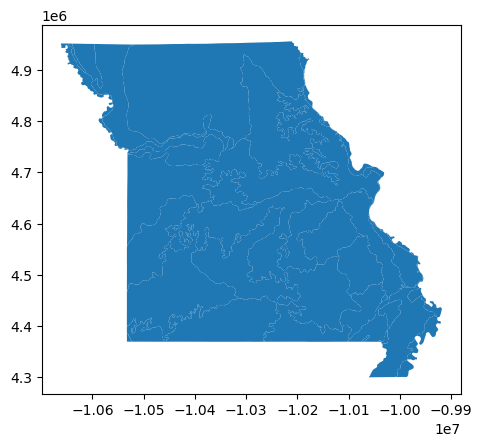

In [3]:
shp_file = gpd.read_file('mo_eco_l4.shp')
shp_file.to_file('mo_eco_l4.geojson', driver='GeoJSON')
MO_eco_l4 = gpd.read_file('mo_eco_l4.geojson', driver='GeoJSON')
MO_eco_l4 = MO_eco_l4.to_crs(crs=3857)
MO_eco_l4.plot()
MO_eco_l4.keys()

In [4]:
overlapping_area = np.empty([len(MO_water_utm),len(MO_eco_l4)])

In [5]:
for i in range(0,len(MO_water_utm)):
    for j in range(0,len(MO_eco_l4)):
        my_polygon = intersection(MO_water_utm.iloc[i].geometry, MO_eco_l4.iloc[j].geometry)
        overlapping_area[i,j] = np.round(my_polygon.area)

# Find index of maximum area along WBID Axis

In [17]:
idx = np.argmax(overlapping_area, axis=1)
US_L3NAME = MO_eco_l4.iloc[idx]['US_L3NAME']
US_L4NAME = MO_eco_l4.iloc[idx]['US_L4NAME']
US_L3NAME.index = MO_water_utm.index
US_L4NAME.index = MO_water_utm.index
print(type(US_L3NAME), type(MO_water_utm['WATER_BODY']))



<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


In [18]:
US_L4NAME

WBID
7001          Loess Flats and Till Plains
7002     Upper Mississippi Alluvial Plain
7003                          River Hills
7004                          River Hills
7005    Middle Mississippi Alluvial Plain
                      ...                
7686                  Wooded Osage Plains
7687                  Wooded Osage Plains
7688                  Wooded Osage Plains
7689                  Wooded Osage Plains
7690                 Eastern Ozark Border
Name: US_L4NAME, Length: 548, dtype: object

In [19]:
final_df = pd.concat([MO_water_utm['WATER_BODY'], US_L3NAME, US_L4NAME], axis=1)
final_df.to_csv("WBID Ecoregime.csv")

In [20]:
final_df

,WATER_BODY,US_L3NAME,US_L4NAME
WBID,,,
7001,Lake of the Oaks,Central Irregular Plains,Loess Flats and Till Plains
7002,Wakonda Lake,Interior River Valleys and Hills,Upper Mississippi Alluvial Plain
7003,Old Lake,Interior River Valleys and Hills,River Hills
7004,Bowling Green Reservoir,Interior River Valleys and Hills,River Hills
7005,Marais Temps Clair,Interior River Valleys and Hills,Middle Mississippi Alluvial Plain
...,...,...,...
7686,Strip Pit 4,Central Irregular Plains,Wooded Osage Plains
7687,Strip Pit 5,Central Irregular Plains,Wooded Osage Plains
7688,Strip Pit 6,Central Irregular Plains,Wooded Osage Plains
